In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
import os
import chess
import chess.engine
import chess.svg
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import display, HTML, clear_output

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_latest_game_moves(directory, tag):
    subfolder = os.path.join(directory, tag)
    if not os.path.exists(subfolder):
        print(f"No saved game models in the directory {subfolder}.")
        return []

    # Find the latest file based on the sequence number
    existing_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
    if not existing_files:
        print(f"No saved games found in {subfolder}.")
        return []

    # Sort files by their sequence number and load the latest
    latest_file = sorted(existing_files, key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)[0]
    latest_path = os.path.join(subfolder, latest_file)
    try:
        game_moves = torch.load(latest_path)
        print(f"Loaded the game moves from {latest_path}")
        return game_moves
    except Exception as e:
        print(f"Failed to load the game moves from {latest_path}: {e}")
        return []

def save_nn_model(game_moves, base_name, tag=""):
    directory = "zmodels"
    subfolder = os.path.join(directory, tag)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    existing_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
    if len(existing_files) >= 10:
        sequence = int(sorted(existing_files)[0].split('_')[-1].split('.')[0])  # Always overwrite the smallest number
    else:
        sequence = len(existing_files) + 1

    filename = f"{base_name}_{sequence:02d}.pth"
    path = os.path.join(subfolder, filename)
    torch.save(game_moves, path)
    print(f"Game moves saved successfully as {filename}")

def save_random_model(game_moves, base_name, tag=""):
    directory = "zmodels"
    subfolder = os.path.join(directory, tag)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    existing_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
    if len(existing_files) >= 10:
        sequence = int(sorted(existing_files)[0].split('_')[-1].split('.')[0])  # Always overwrite the smallest number
    else:
        sequence = len(existing_files) + 1

    filename = f"{base_name}_{sequence:02d}.pth"
    path = os.path.join(subfolder, filename)
    torch.save(game_moves, path)
    print(f"Game moves saved successfully as {filename}")


def select_move_random(board, aggressive=False):
    moves = list(board.legal_moves)
    if aggressive:
        captures = [move for move in moves if board.is_capture(move)]
        if captures:
            return random.choice(captures)  # Prefer capture moves if available
    return random.choice(moves) if moves else None



In [224]:
def load_latest_game_moves(directory, tag):
    subfolder = os.path.join(directory, tag)
    if not os.path.exists(subfolder):
        print(f"No saved game models in the directory {subfolder}.")
        return []

    # Find the latest file based on the sequence number
    existing_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
    if not existing_files:
        print(f"No saved games found in {subfolder}.")
        return []

    # Sort files by their sequence number and load the latest
    latest_file = sorted(existing_files, key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)[0]
    latest_path = os.path.join(subfolder, latest_file)
    try:
        game_moves = torch.load(latest_path)
        print(f"Loaded the game moves from {latest_path}")
        return game_moves
    except Exception as e:
        print(f"Failed to load the game moves from {latest_path}: {e}")
        return []


def save_random_model(game_moves, base_name, tag=""):
    directory = "zmodels"
    subfolder = os.path.join(directory, tag)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    existing_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
    if len(existing_files) >= 10:
        sequence = int(sorted(existing_files)[0].split('_')[-1].split('.')[0])  # Always overwrite the smallest number
    else:
        sequence = len(existing_files) + 1

    filename = f"{base_name}_{sequence:02d}.pth"
    path = os.path.join(subfolder, filename)
    torch.save(game_moves, path)
    print(f"Game moves saved successfully as {filename}")


def select_move_random(board, aggressive=False):
    moves = list(board.legal_moves)
    if aggressive:
        captures = [move for move in moves if board.is_capture(move)]
        if captures:
            return random.choice(captures)  # Prefer capture moves if available
    return random.choice(moves) if moves else None

def load_game_moves(saved_game_path):
    try:
        return torch.load(saved_game_path)
    except FileNotFoundError:
        print(f"No saved game found at {saved_game_path}, starting with fresh games.")
        return []

def train_model_with_saved_moves(episodes, saved_game_path=None, save_path="random_chess_model", max_moves=100):
    saved_game_moves = load_game_moves(saved_game_path) if saved_game_path else []
    for episode in range(episodes):
        board = chess.Board()
        game_moves = []
        turn_index = 0
        move_count = 0

        while not board.is_game_over():
            if move_count >= max_moves:
                print("Max moves reached, forcing end-game strategies.")
                break

            if board.turn == chess.WHITE:
                if turn_index < len(saved_game_moves) and chess.Move.from_uci(saved_game_moves[turn_index]) in board.legal_moves:
                    move = chess.Move.from_uci(saved_game_moves[turn_index])
                    turn_index += 1
                else:
                    break
            else:
                move = select_move_random(board, aggressive=True if move_count > max_moves - 10 else False)

            if move:
                board.push(move)
                game_moves.append(move.uci())
                move_count += 1
            else:
                break

        result = board.result()
        if result == '0-1':  # Black wins
            save_random_model(game_moves, save_path, tag="winning")
            print(f"Black wins! Game saved as new model at {save_path}.")
        elif result == '1-0':  # White wins
            save_random_model(game_moves, save_path, tag="winning")
            print(f"White wins! Game saved as new model at {save_path}.")
        else:
            save_random_model(game_moves, save_path, tag="draws")
            print("Draw! Game saved in draw models.")

# Assuming your models are saved under "models/winning" or "models/draws"
saved_game_path = load_latest_game_moves("zmodels", "draws")  # Change "winning" to "draws" or other tags as needed

# Now use this path in your training function
train_model_with_saved_moves(10, saved_game_path=saved_game_path)



Loaded the game moves from zmodels/draws/random_chess_model_10.pth
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.
Game moves saved successfully as random_chess_model_01.pth
Draw! Game saved in draw models.


In [189]:
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()        
        # Input layer: 64*12 units (one-hot encoding of the board for each of the 12 types of pieces)
        self.fc1 = nn.Linear(64 * 12, 512)
        self.relu1 = nn.ReLU()  # Activation function for the first hidden layer
        self.dropout1 = nn.Dropout(0.1)  # Dropout layer for regularization
        
        # Second hidden layer
        self.fc2 = nn.Linear(512, 1024)
        self.relu2 = nn.ReLU()  # Activation function for the second hidden layer
        self.dropout2 = nn.Dropout(0.1)  # Dropout layer for regularization
        
        # Output layer: 64*64 units (one value for each possible move)
        self.fc3 = nn.Linear(1024, 64 * 64)  # Output layer

    def forward(self, x):
        # Define the forward pass through the neural network
        x = self.fc1(x)  # Pass input through the first fully connected layer
        x = self.relu1(x)  # Apply ReLU activation function
        x = self.dropout1(x)  # Apply dropout for regularization
        
        x = self.fc2(x)  # Pass input through the second fully connected layer
        x = self.relu2(x)  # Apply ReLU activation function
        x = self.dropout2(x)  # Apply dropout for regularization
        
        x = self.fc3(x)  # Pass input through the output layer
        return x  # Return the output


In [190]:
class ReplayBuffer:
    def __init__(self, capacity):
        # Initialize a deque data structure with a maximum capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Add a tuple containing the state, action, reward, next_state, and done flag to the buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Sample a batch of transitions randomly from the buffer
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        # Return the current length of the buffer
        return len(self.buffer)


In [191]:
# Function to convert a chess board to a tensor representation
def board_to_tensor(board):
    # Initialize a tensor with zeros, representing the board
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)
    
    # Dictionary mapping piece symbols to indices in the tensor
    piece_to_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,
                    'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
    
    # Loop through each square on the chess board
    for i in range(64):
        # Get the piece at the current square
        piece = board.piece_at(i)
        
        # If there is a piece on the square
        if piece is not None:
            # Get the index of the piece in the tensor representation
            piece_idx = piece_to_idx.get(piece.symbol(), -1)
            
            # If the piece is recognized
            if piece_idx != -1:
                # Convert the square index to row and column
                row, col = divmod(i, 8)
                
                # Set the corresponding position in the tensor to 1 to indicate the presence of the piece
                board_tensor[piece_idx, row, col] = 1
                
    # Flatten the tensor and return
    return board_tensor.flatten()


In [192]:
# Function to select a move based on the given model and board state
def select_move(model, board, epsilon=0.2):
    # Get a list of legal moves for the current board state
    legal_moves = list(board.legal_moves)
    
    # If there are no legal moves available, return None and a score of 0
    if not legal_moves:
        return None, 0
    
    # Exploration: randomly choose a move with probability epsilon
    if random.random() < epsilon:
        # Choose a random move from the list of legal moves
        move = random.choice(legal_moves)
        
        # Return the randomly chosen move and a score of 0 (since it's random)
        return move, 0
    
    else:  # Exploitation: use the model to choose the best move
        # Convert the current board state into a tensor representation
        board_tensor = torch.FloatTensor([board_to_tensor(board)])
        
        # Disable gradient calculation during inference
        with torch.no_grad():
            # Get the model's predictions for the board state
            predictions = model(board_tensor).view(64, 64)
        
        # Calculate scores for each legal move based on the model's predictions
        move_scores = {move: predictions[move.from_square, move.to_square].item() for move in legal_moves}
        
        # Choose the move with the highest score
        best_move = max(move_scores, key=move_scores.get)
        
        # Return the best move and its corresponding score
        return best_move, move_scores[best_move]


In [193]:
def penalize_repetition(moves_history, current_move):
    return -0.1 if current_move in moves_history[-10:] else 0 # Penalize if move is repeated within the last 10 moves

def check_too_many_draws(draw_counter, threshold=5):
    return draw_counter >= threshold  # Returns True if too many draws

def piece_value(piece):
    values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0.01}
    return values.get(piece.symbol().upper(), 0)

# def positional_reward(board):
#     center_squares = [chess.D4, chess.D5, chess.E4, chess.E5]
#     reward = 0.1 * sum(1 for square in center_squares if board.piece_at(square))
#     return reward

# Basic method to give a reward based on what piece is captured
def get_move_reward(board, move):
    reward = 0
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        reward += piece_value(captured_piece)
    # reward += positional_reward(board)
    return reward

def get_game_reward(result):
    # Defines reward based on the game result
    if result == "1-0":  # White wins
        return 1
    elif result == "0-1":  # Black wins
        return -1
    else:  # Draw
        return 0

In [194]:
def plot_training_progress(losses, moves_per_episode, nn_moves, random_moves, outcomes, fig, axs, window=10):
    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Smooth losses
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window) / window, mode='valid')
    else:
        smoothed_losses = losses  # Not enough data to smooth, use raw data

    # Plotting losses
    axs[0, 0].clear()
    axs[0, 0].plot(smoothed_losses, label='Loss per Episode')
    axs[0, 0].set_title('Training Losses')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plotting moves per episode
    axs[0, 1].clear()
    axs[0, 1].plot(moves_per_episode, label='Total Moves per Episode')
    axs[0, 1].set_title('Moves per Episode')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Total Moves')
    axs[0, 1].legend()

    # Plotting move type counts
    axs[1, 0].clear()
    axs[1, 0].plot(nn_moves, label='NN Moves Count')
    axs[1, 0].plot(random_moves, label='Random Moves Count')
    axs[1, 0].set_title('Move Types per Episode')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].legend()

    # Plotting game outcomes
    axs[1, 1].clear()
    outcomes_series = pd.Series(outcomes).value_counts().plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title('Game Outcomes')
    axs[1, 1].set_xlabel('Result')
    axs[1, 1].set_ylabel('Frequency')

    clear_output(wait=True)
    display(fig)

    return fig, axs


In [195]:
def train_model(model, optimizer, episodes=50, gamma=0.9, replay_buffer_capacity=10000, batch_size=8):
    # Initialize replay buffer, loss function, and tracking variables
    replay_buffer = ReplayBuffer(capacity=replay_buffer_capacity)
    loss_fn = torch.nn.MSELoss()
    dataframe, losses, moves_per_episode, white_scores, black_scores, nn_move_counts, random_move_counts, outcomes = [], [], [], [], [], [], [], []
    fig, axs = None, None
    draw_counter = 0  # Track consecutive draws

    # Loop over episodes
    for episode in range(episodes):
        board = chess.Board()
        moves_history = []
        episode_moves = []
        total_loss = 0
        white_score = black_score = 0
        nn_move_count, random_move_count = 0, 0
        initial_epsilon = 0.9
        min_epsilon = 0.1
        epsilon_decay = 0.995

        # Inner loop until the game ends
        while not board.is_game_over():
            # Update epsilon for epsilon-greedy strategy
            epsilon = max(min_epsilon, initial_epsilon * (epsilon_decay ** episode))

            current_turn = "White" if board.turn == chess.WHITE else "Black"
            move, score = select_move(model, board, epsilon)
            if move is None:
                break
            board.push(move)
            moves_history.append(move.uci())

            move_type = "random" if score == 0 else "NN"
            if move_type == "NN":
                nn_move_count += 1
            else:
                random_move_count += 1

            move_detail = {
                "color": current_turn,
                "move": move.uci(),
                "type": move_type,
                "score": score if score != 0 else None
            }
            episode_moves.append(move_detail)


            # Check and penalize for repeated moves
            repetition_penalty = penalize_repetition(moves_history, move.uci())

            # Calculate reward and update the replay buffer
            move_reward = get_move_reward(board, move) + repetition_penalty
            next_state = board_to_tensor(board) if not board.is_game_over() else None
            replay_buffer.push(board_to_tensor(board), move, move_reward, next_state, board.is_game_over())
            
            white_score += move_reward if board.turn == chess.BLACK else 0
            black_score += move_reward if board.turn == chess.WHITE else 0

            # Training from the buffer
            if len(replay_buffer) > batch_size:
                # Sample a batch of transitions from the replay buffer
                batch = replay_buffer.sample(batch_size)
                # Iterate over the batch
                for state, action, reward, next_state, done in batch:
                    # Calculate the target reward using the Bellman equation
                    target_reward = reward if done else reward + gamma * model(torch.FloatTensor([next_state])).max().item()
                    # Predicted reward by the model for the current state
                    predicted_reward = model(torch.FloatTensor([state]))
                    # Calculate the loss between predicted and target rewards
                    loss = loss_fn(predicted_reward, torch.tensor([target_reward]))
                    # Zero the gradients, perform backpropagation, and update the model parameters
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    # Accumulate the total loss for the current episode
                    total_loss += loss.item()


        result = board.result() if board.result() is not "*" else "DNF"
        outcomes.append(result)
        losses.append(total_loss)
        white_scores.append(white_score)
        black_scores.append(black_score)
        moves_per_episode.append(len(moves_history))
        nn_move_counts.append(nn_move_count)
        random_move_counts.append(random_move_count)

        dataframe.append({
            "Episode": episode + 1,
            "Loss": total_loss,
            "Result": result,
            "Winner": 'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw',
            "White Score": white_score,
            "Black Score": black_score,
            "Moves Per Episode": moves_per_episode,
            "NN Move Count": nn_move_counts,
            "Random Move Count": random_move_counts,
            "Moves": episode_moves
        })

        # Handle excessive draws
        if result == '1/2-1/2':
            draw_counter += 1
        else:
            draw_counter = 0

        if check_too_many_draws(draw_counter):
            print("Switching to training against a previous model version due to excessive draws.")
            # TODO
            draw_counter = 0

        # Calculate the condition based on the number of episodes
        if episodes <= 100:
            should_plot = True 
        else:
            should_plot = episode % 10 == 0 or episode == episodes - 1 

        # Apply the plotting condition
        if should_plot:
            fig, axs = plot_training_progress(losses, moves_per_episode, nn_move_counts, random_move_counts, outcomes, fig, axs)

        print(f"Episode {episode + 1}: Loss = {total_loss:.4f}, Result = {result}, Winner = {'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw'}, Moves Count = {len(episode_moves)}, Moves = {episode_moves}")

    df = pd.DataFrame(dataframe)
    return df



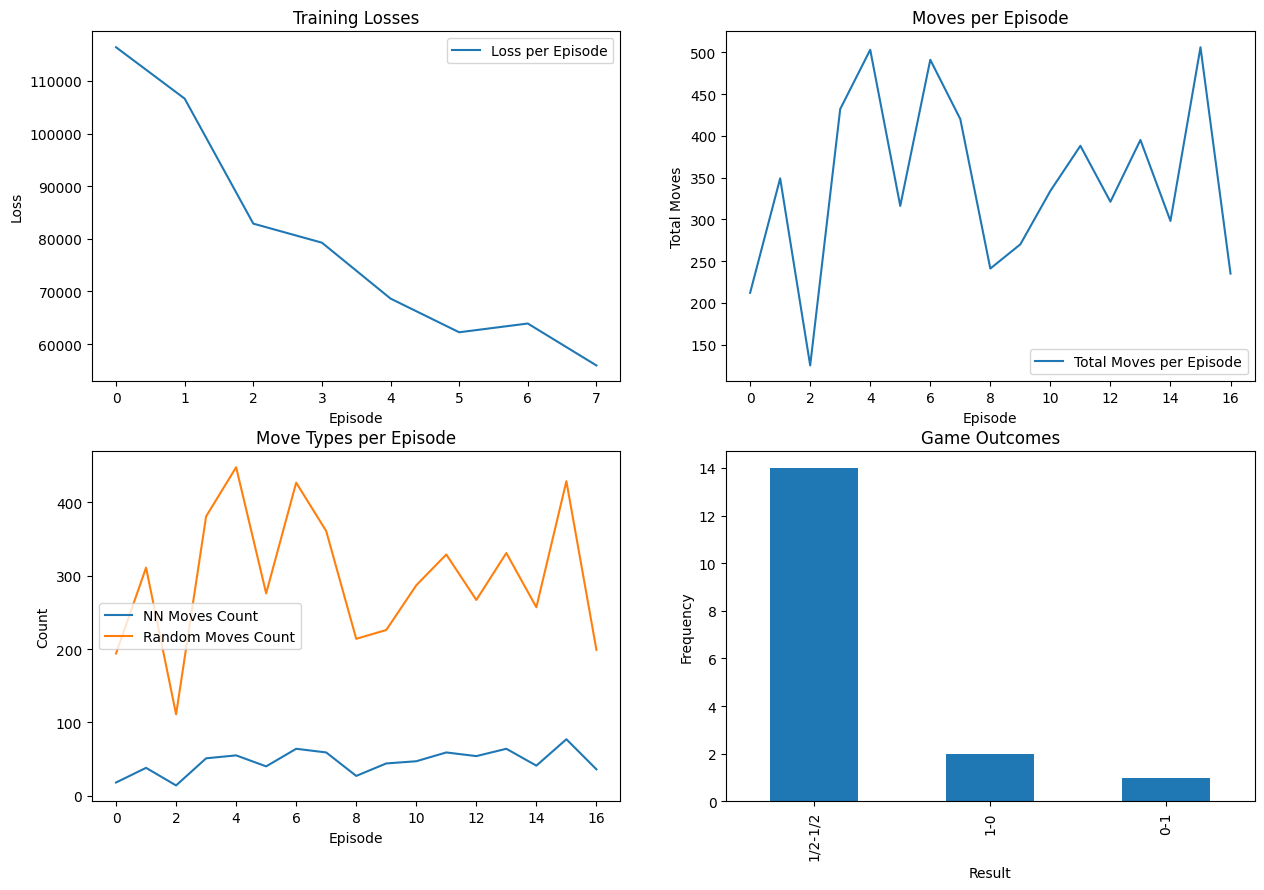

Episode 17: Loss = 32758.2299, Result = 1-0, Winner = White, Moves Count = 235, Moves = [{'color': 'White', 'move': 'g1h3', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'h7h6', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'h3g5', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'g8f6', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'g5f7', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'b8c6', 'type': 'NN', 'score': 20.828170776367188}, {'color': 'White', 'move': 'b2b4', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'c6e5', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'f7e5', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'e7e6', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'a2a3', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'h8h7', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'd2d4', 'type': 'random', 'score': None}, {'co

In [196]:
# Create an instance of the ChessNN model
model = ChessNN()

# Initialize the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using the defined model, optimizer, and number of episodes
results = train_model(model, optimizer, episodes=100)


In [ ]:
# results.head(5)
# results.tail(5)
print(results['Winner'].value_counts())
print(results['Moves'].value_counts())
# with pd.option_context('display.max_colwidth', None):
#     print(results)

Winner
Draw     88
Black     7
White     5
Name: count, dtype: int64
Moves
[{'color': 'Black', 'move': 'a2a3', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'c7c6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'e2e3', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'c6c5', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'g1e2', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'g7g5', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'h1g1', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'g8f6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'f2f4', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'd7d6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'h2h4', 'type': 'random', 'score': None}, {'color': 'White', 'move': 'c8e6', 'type': 'random', 'score': None}, {'color': 'Black', 'move': 'e2d4', 'type': 'random', 'score': None}, {'color': 'White', 'move': 

In [ ]:
torch.save(model.state_dict(), 'chess_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
model = ChessNN()
model.load_state_dict(torch.load('chess_model.pth'))
model.eval()
print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


In [ ]:
# Function to watch the model play a game of chess
def watch_model_play(model, ignore_draws=False, ignore_fivefold_repetition=False, ignore_seventyfive_moves=False):
    # Initialize a chess board
    board = chess.Board()
    move_count = 0
    
    # Continue playing until the game is over or a maximum number of moves is reached
    while True:
        if move_count > 250:
            print("Stopping due to too many moves")
            break
        
        # Check if the game is over
        if board.is_game_over():
            if board.is_checkmate():
                print("Checkmate.")
                break
            elif not ignore_draws or not ignore_fivefold_repetition or not ignore_seventyfive_moves:
                # Print out the reason for a draw if it can be claimed
                if board.can_claim_draw():
                    print("Draw can be claimed.")
                if board.is_stalemate():
                    print("Stalemate reached.")
                if board.is_insufficient_material():
                    print("Insufficient material for a checkmate.")
                if not ignore_seventyfive_moves and board.is_seventyfive_moves():
                    print("75-move rule reached.")
                if not ignore_fivefold_repetition and board.is_fivefold_repetition():
                    print("Fivefold repetition reached.")
                if board.is_variant_draw():
                    print("Draw by variant-specific rules.")
                break
        
        # Select a move using the model with epsilon=0 (exploitation)
        result = select_move(model, board, epsilon=0)
        
        # If no legal moves are available, end the game
        if result is None:
            print("No legal moves available")
            break
        
        # Make the selected move and update the board
        move, score = result
        board.push(move)
        
        # Clear the output and display the updated board
        clear_output(wait=True)
        display(HTML(chess.svg.board(board=board, lastmove=move, size=400)))
        print("Move:", move.uci())
        print("White to move" if board.turn else "Black to move")
        time.sleep(.1)  # Increase delay for visibility
        move_count += 1

    # Print the result of the game and the total move count
    print(f"\nGame result: {board.result()}")
    print("Move Count:", move_count)

# Testing the function with draw conditions ignored
watch_model_play(model, ignore_draws=True, ignore_fivefold_repetition=True, ignore_seventyfive_moves=True)


Move: c1d1
Black to move


KeyboardInterrupt: 